In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/ge"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [3]:
models = [
    #"CADD.RawScore",
    "phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

embedding_models = [
    "Enformer",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,phyloP-100-vertebrates
0,1,14677,G,A,0.992227,0.055024,True,0,-0.452
1,1,54490,G,A,1.000000,0.159938,True,1,0.313
2,1,63671,G,A,0.998592,0.156388,True,2,1.392
3,1,63697,T,C,0.977568,0.195652,True,3,-1.155
4,1,108826,G,C,1.000000,0.040023,True,4,0.306
...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,0.603
21572,X,155559972,A,T,0.008540,0.279240,False,10678,-1.903
21573,X,155672303,G,A,0.962191,0.436727,True,10785,-0.075
21574,X,155768650,G,T,0.991784,0.455970,True,10786,-2.212


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,phyloP-100-vertebrates,Enformer_feature_0,...,GPN-MSA-256_embedding_758,GPN-MSA-256_embedding_759,GPN-MSA-256_embedding_760,GPN-MSA-256_embedding_761,GPN-MSA-256_embedding_762,GPN-MSA-256_embedding_763,GPN-MSA-256_embedding_764,GPN-MSA-256_embedding_765,GPN-MSA-256_embedding_766,GPN-MSA-256_embedding_767
0,1,14677,G,A,0.992227,0.055024,True,0,-0.452,NaN,...,229.593536,220.271881,222.814026,270.584656,151.918854,130.458313,343.643860,480.939758,224.645905,284.675354
1,1,54490,G,A,1.000000,0.159938,True,1,0.313,-0.000068,...,226.143341,207.161392,84.297295,137.732880,87.787094,180.787872,238.734619,355.652740,262.366272,184.158600
2,1,63671,G,A,0.998592,0.156388,True,2,1.392,-0.000170,...,120.956596,252.821579,169.802338,177.228928,215.953979,292.334656,197.623932,356.462036,247.294586,302.947388
3,1,63697,T,C,0.977568,0.195652,True,3,-1.155,NaN,...,129.283478,247.526413,169.091461,179.492065,228.314209,304.287720,213.892715,334.712341,254.674896,321.902496
4,1,108826,G,C,1.000000,0.040023,True,4,0.306,NaN,...,185.487549,191.590363,92.084404,168.260635,66.487068,129.655029,275.621490,322.402527,197.829163,161.046600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,0.603,NaN,...,215.521164,340.427185,222.008850,245.215637,245.004150,199.100433,301.094482,394.382080,277.259827,98.517487
21572,X,155559972,A,T,0.008540,0.279240,False,10678,-1.903,NaN,...,170.262024,123.263870,106.353622,185.809113,238.228378,217.703766,320.996033,291.326172,370.695007,382.042175
21573,X,155672303,G,A,0.962191,0.436727,True,10785,-0.075,NaN,...,195.571228,561.805359,322.421204,546.414307,232.165833,244.519318,609.989807,432.213745,201.975662,74.191048
21574,X,155768650,G,T,0.991784,0.455970,True,10786,-2.212,NaN,...,271.074951,154.110291,144.139908,201.432083,250.635162,254.858505,610.124329,181.424454,408.263184,364.471710


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

In [6]:
V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
models.append("Enformer_l2")

In [6]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,phyloP-100-vertebrates,Enformer_feature_0,...,GPN-MSA-256_embedding_758,GPN-MSA-256_embedding_759,GPN-MSA-256_embedding_760,GPN-MSA-256_embedding_761,GPN-MSA-256_embedding_762,GPN-MSA-256_embedding_763,GPN-MSA-256_embedding_764,GPN-MSA-256_embedding_765,GPN-MSA-256_embedding_766,GPN-MSA-256_embedding_767
1,1,54490,G,A,1.000000,0.159938,True,1,0.313,-0.000068,...,226.143341,207.161392,84.297295,137.732880,87.787094,180.787872,238.734619,355.652740,262.366272,184.158600
2,1,63671,G,A,0.998592,0.156388,True,2,1.392,-0.000170,...,120.956596,252.821579,169.802338,177.228928,215.953979,292.334656,197.623932,356.462036,247.294586,302.947388
5,1,286747,A,G,1.000000,0.151295,True,5,-0.331,-0.000004,...,233.298279,535.351807,242.234070,502.682831,222.888031,239.357178,536.432739,453.516205,181.162201,104.409714
7,1,912710,G,A,0.008546,0.222110,False,482,1.960,-0.000007,...,186.737549,179.323730,158.358444,144.520630,65.013557,104.976006,306.811096,370.677704,154.514297,256.240570
8,1,917584,T,G,0.996919,0.199664,True,7,-1.155,-0.000465,...,143.598068,134.241150,183.064026,296.645142,115.280952,231.542938,417.471436,273.275543,347.280579,223.286865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,22,50665387,T,A,0.006481,0.030702,False,10404,0.134,-0.000004,...,149.954865,261.802185,121.686722,206.714752,205.991287,132.359741,265.181061,394.613098,249.168304,159.359314
21048,22,50665389,G,A,0.006481,0.030702,False,10418,0.134,-0.000000,...,152.180176,262.403992,122.918739,211.472443,202.602066,130.826660,268.516724,396.510864,245.766434,156.898300
21049,22,50733265,G,A,0.971032,0.302632,True,10523,0.950,-0.000037,...,153.377258,123.564301,96.271866,193.328033,163.787079,172.478394,339.293182,314.293793,176.762360,281.547607
21050,22,50783672,G,T,0.964513,0.080189,True,10524,-0.321,-0.002810,...,74.859604,184.666443,120.494644,125.871414,218.429337,89.712509,395.704651,356.475067,160.950943,257.074707


In [7]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     9321
False    9321
Name: count, dtype: int64

In [8]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []

for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))

#supervised_models.append((
#    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
#    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
#))

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
Enformer - LR(inner products)
GPN-MSA - LR(inner products)
NT - LR(inner products)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

HyenaDNA - LR(inner products)
GPN-MSA-256 - LR(inner products)
['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
Enformer - LR(inner products)
GPN-MSA - LR(inner products)
NT - LR(inner products)


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

HyenaDNA - LR(inner products)
GPN-MSA-256 - LR(inner products)


## Testing

In [9]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 6/6 [00:00<00:00, 98.03it/s]


,Model,AUROC
1,Enformer - LR(inner products),0.775451
3,NT - LR(inner products),0.755150
5,GPN-MSA-256 - LR(inner products),0.735819
2,GPN-MSA - LR(inner products),0.729127
4,HyenaDNA - LR(inner products),0.686906
0,phyloP-100-vertebrates,0.514866


In [10]:
#results.to_parquet("results_eqtl.parquet", index=False)

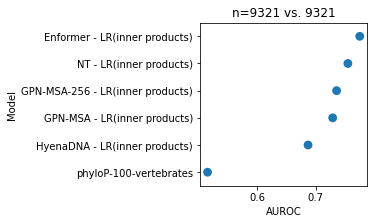

In [11]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);